In [ ]:
# 2群の平均値の差をベイズ推定（≒t検定）
# bayesian analytics on the difference of two means called t_test
# for AB testing on multinomial like revenue

# pymc3バージョン

In [1]:
# import
import pandas as pd
import numpy as np
# from scipy.stats import beta
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm
import theano.tensor as tt
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
import sys
print('Python v{}'.format(sys.version))
print('Pandas v{}'.format(pd.__version__))
print('Numpy v{}'.format(np.__version__))
import matplotlib
print(f"Matplotlib v{matplotlib.__version__}")

print('PyMC3 v{}'.format(pm.__version__))
print('Arviz v{}'.format(az.__version__))

Python v3.9.6 (default, Sep 19 2022, 18:46:30) 
[Clang 14.0.0 (clang-1400.0.29.201)]
Pandas v1.5.1
Numpy v1.22.1
Matplotlib v3.6.1
PyMC3 v3.11.5
Arviz v0.12.1


In [3]:
# read_data

x_A = [
    1.96, 2.06, 2.03, 2.11, 1.88, 1.88, 2.08, 1.93, 2.03, 2.03, 2.03, 2.08, 2.03, 2.11, 1.93    
]

In [4]:
x_B = [
    1.83, 1.93, 1.88, 1.85, 1.85, 1.91, 1.91, 1.85, 1.78, 1.91, 1.93, 1.80, 1.80, 1.85, 1.93, 
    1.85, 1.83, 1.85, 1.91, 1.85, 1.91, 1.85, 1.80, 1.80, 1.85
    
]

In [5]:
# data_check

print(x_A)
print(x_B)
print(len(x_A))
print(len(x_B))

[1.96, 2.06, 2.03, 2.11, 1.88, 1.88, 2.08, 1.93, 2.03, 2.03, 2.03, 2.08, 2.03, 2.11, 1.93]
[1.83, 1.93, 1.88, 1.85, 1.85, 1.91, 1.91, 1.85, 1.78, 1.91, 1.93, 1.8, 1.8, 1.85, 1.93, 1.85, 1.83, 1.85, 1.91, 1.85, 1.91, 1.85, 1.8, 1.8, 1.85]
15
25


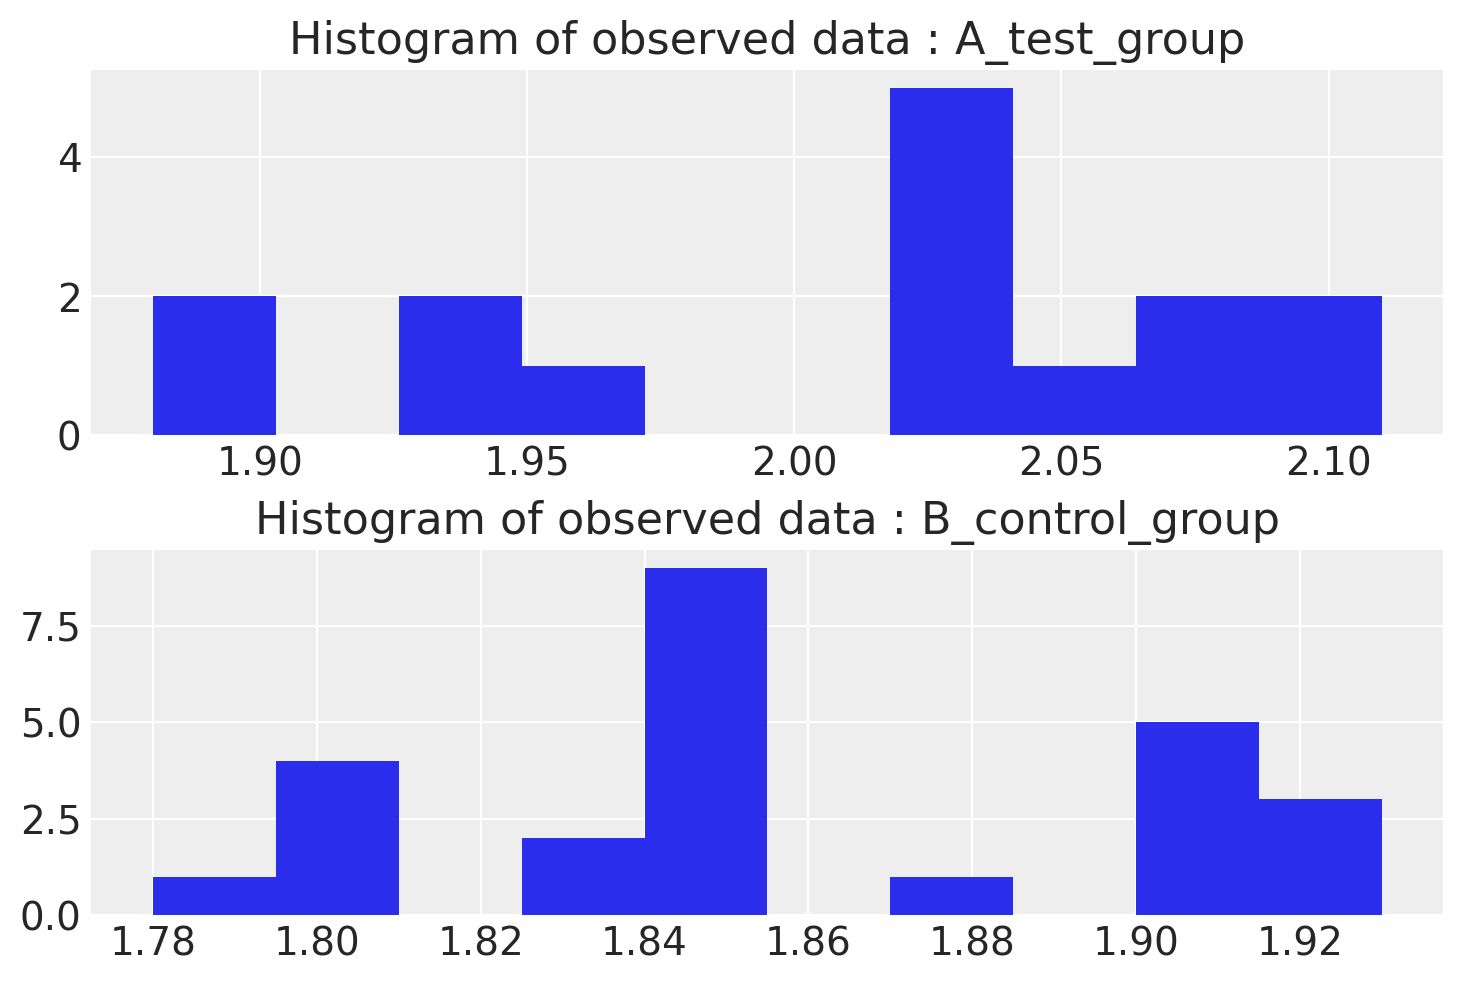

In [6]:
# histogram

figure, axes = plt.subplots(2,1, constrained_layout=True)
axes[0].hist(x_A)
axes[1].hist(x_B)
axes[0].set_title("Histogram of observed data : A_test_group")
axes[1].set_title("Histogram of observed data : B_control_group")
plt.show()

In [7]:
# model_creation
# prior_distributions_of_mu

pooled_mean = np.r_[x_A, x_B].mean()
pooled_std = np.r_[x_A, x_B].std() * 2

with pm.Model() as model:
    mu_A = pm.Normal('mu_A', mu=pooled_mean, sd=pooled_std)
    mu_B = pm.Normal('mu_B', mu=pooled_mean, sd=pooled_std)

In [8]:
# prior_distributions_of_sigma

std_low = 1
std_high = 10

with model:
    std_A = pm.Uniform('std_A', lower=std_low, upper=std_high)
    std_B = pm.Uniform('std_B', lower=std_low, upper=std_high)

In [9]:
# prior_distributions_of_nu

with model:
    nu_minus_1 = pm.Exponential('nu_minus_1', 1/29) + 1

In [10]:
with model:
    obs_A = pm.StudentT('obs_A', mu=mu_A, sigma=std_A, nu=nu_minus_1, observed=x_A)
    obs_B = pm.StudentT('obs_B', mu=mu_B, sigma=std_B, nu=nu_minus_1, observed=x_B)

In [11]:
with model:
    mu_diff = pm.Deterministic('absolute_difference_of_means', mu_A - mu_B)
    std_diff = pm.Deterministic('absolute_difference_of_stds', std_A - std_B)
    effect_size = pm.Deterministic('effect_size', mu_diff / np.sqrt((std_A**2 + std_B**2) / 2))
    mu_diff_rr = pm.Deterministic('relative_difference_of_means', (mu_A - mu_B) / mu_B)

In [12]:
# sampling
with model:
    start = pm.find_MAP()
    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=2000, initvals=start, cores=4, return_inferencedata=True)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_1, std_B, std_A, mu_B, mu_A]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


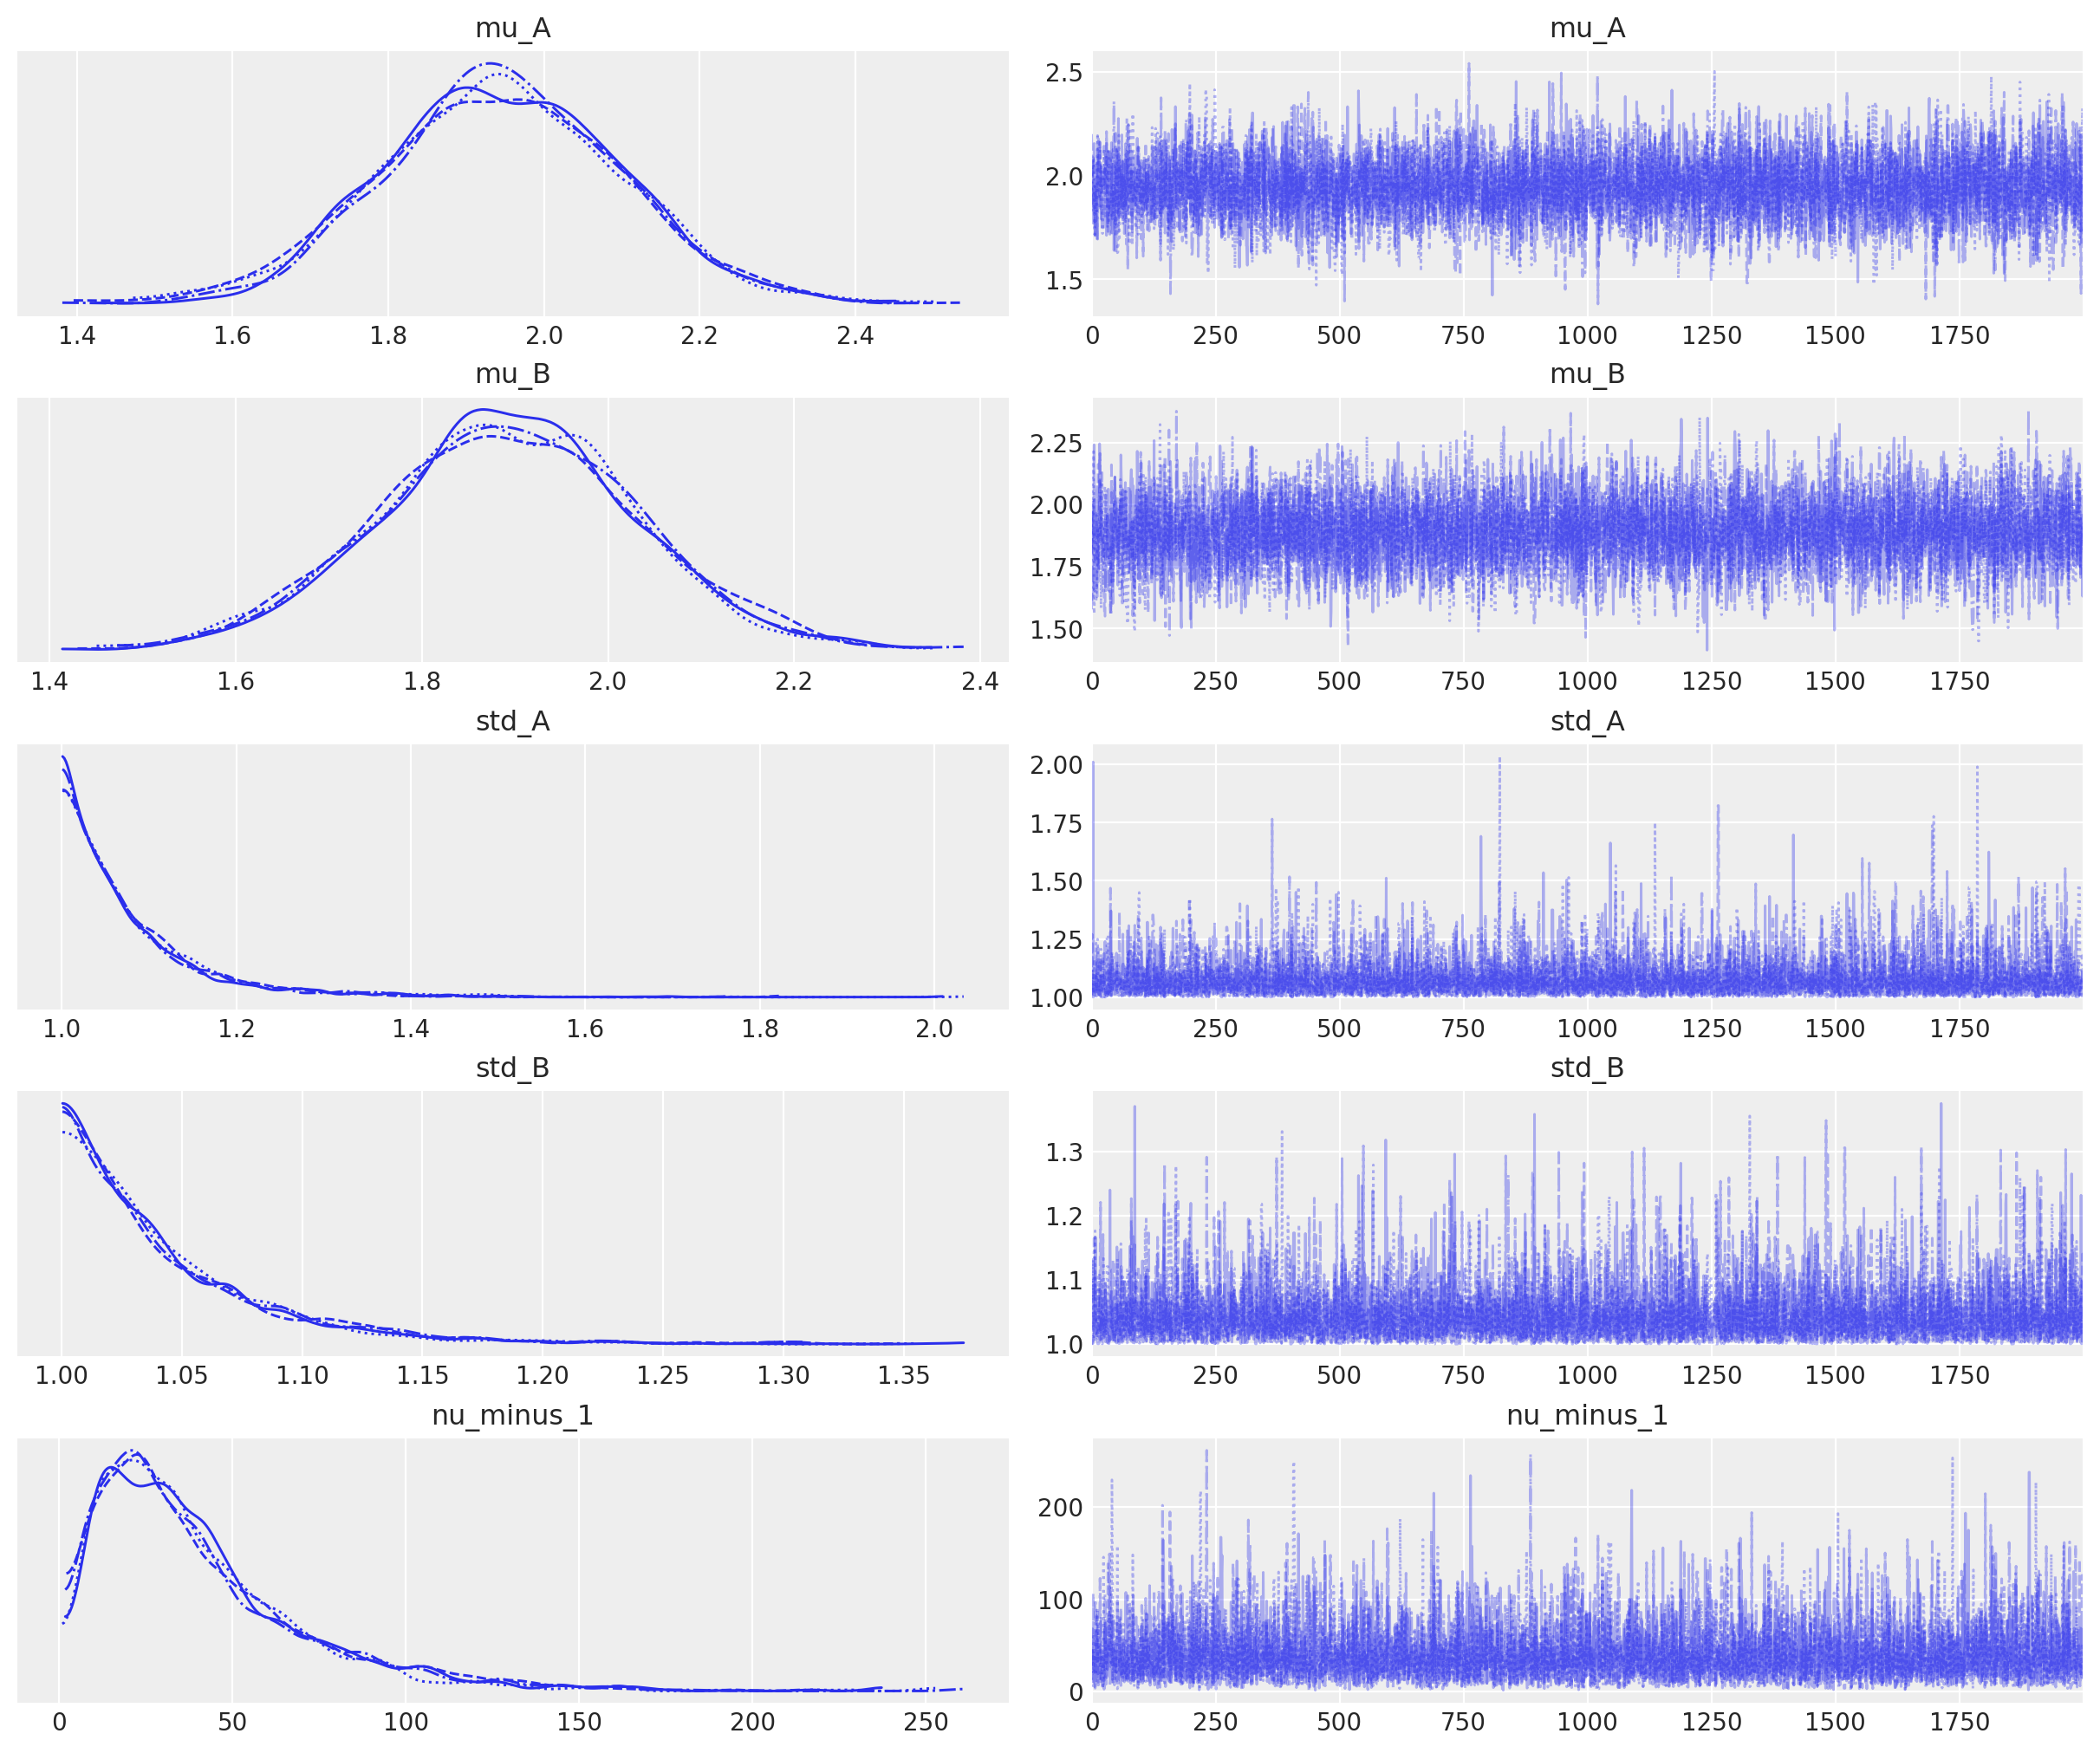

In [13]:
# analyze sampling results
# trace_plot
# az.plot_trace(trace);
az.plot_trace(trace, var_names=["mu_A", "mu_B", "std_A", "std_B", "nu_minus_1"]);

In [14]:
# summary_plot
# az.summary(trace, hdi_prob=0.95)
az.summary(trace, hdi_prob=0.8)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_A,1.945,0.154,1.743,2.135,0.002,0.001,7139.0,5246.0,1.0
mu_B,1.891,0.138,1.714,2.065,0.002,0.001,5541.0,5167.0,1.0
std_A,1.079,0.087,1.000,1.124,0.001,0.001,6239.0,3490.0,1.0
std_B,1.045,0.046,1.000,1.071,0.001,0.000,5100.0,3008.0,1.0
nu_minus_1,40.404,30.844,4.202,61.833,0.374,0.288,6924.0,5220.0,1.0
absolute_difference_of_means,0.054,0.207,-0.215,0.315,0.003,0.002,6464.0,4919.0,1.0
absolute_difference_of_stds,0.035,0.098,-0.074,0.124,0.001,0.001,7594.0,5691.0,1.0
effect_size,0.051,0.195,-0.195,0.305,0.002,0.002,6634.0,5229.0,1.0
relative_difference_of_means,0.034,0.112,-0.121,0.163,0.001,0.001,6358.0,5021.0,1.0


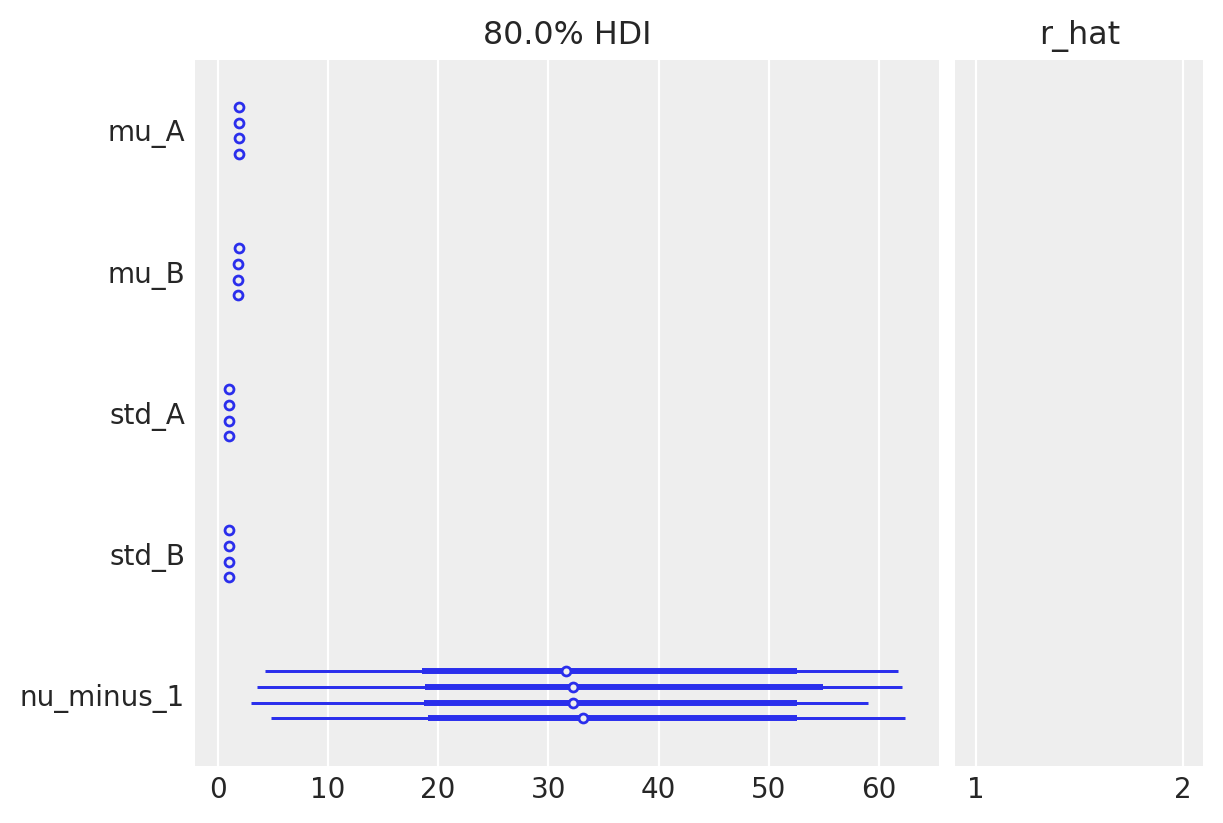

In [15]:
# foresplot

az.plot_forest(trace, r_hat=True, hdi_prob=0.8, figsize=(6,4), textsize=10,
              var_names=["mu_A", "mu_B", "std_A", "std_B", "nu_minus_1"]);

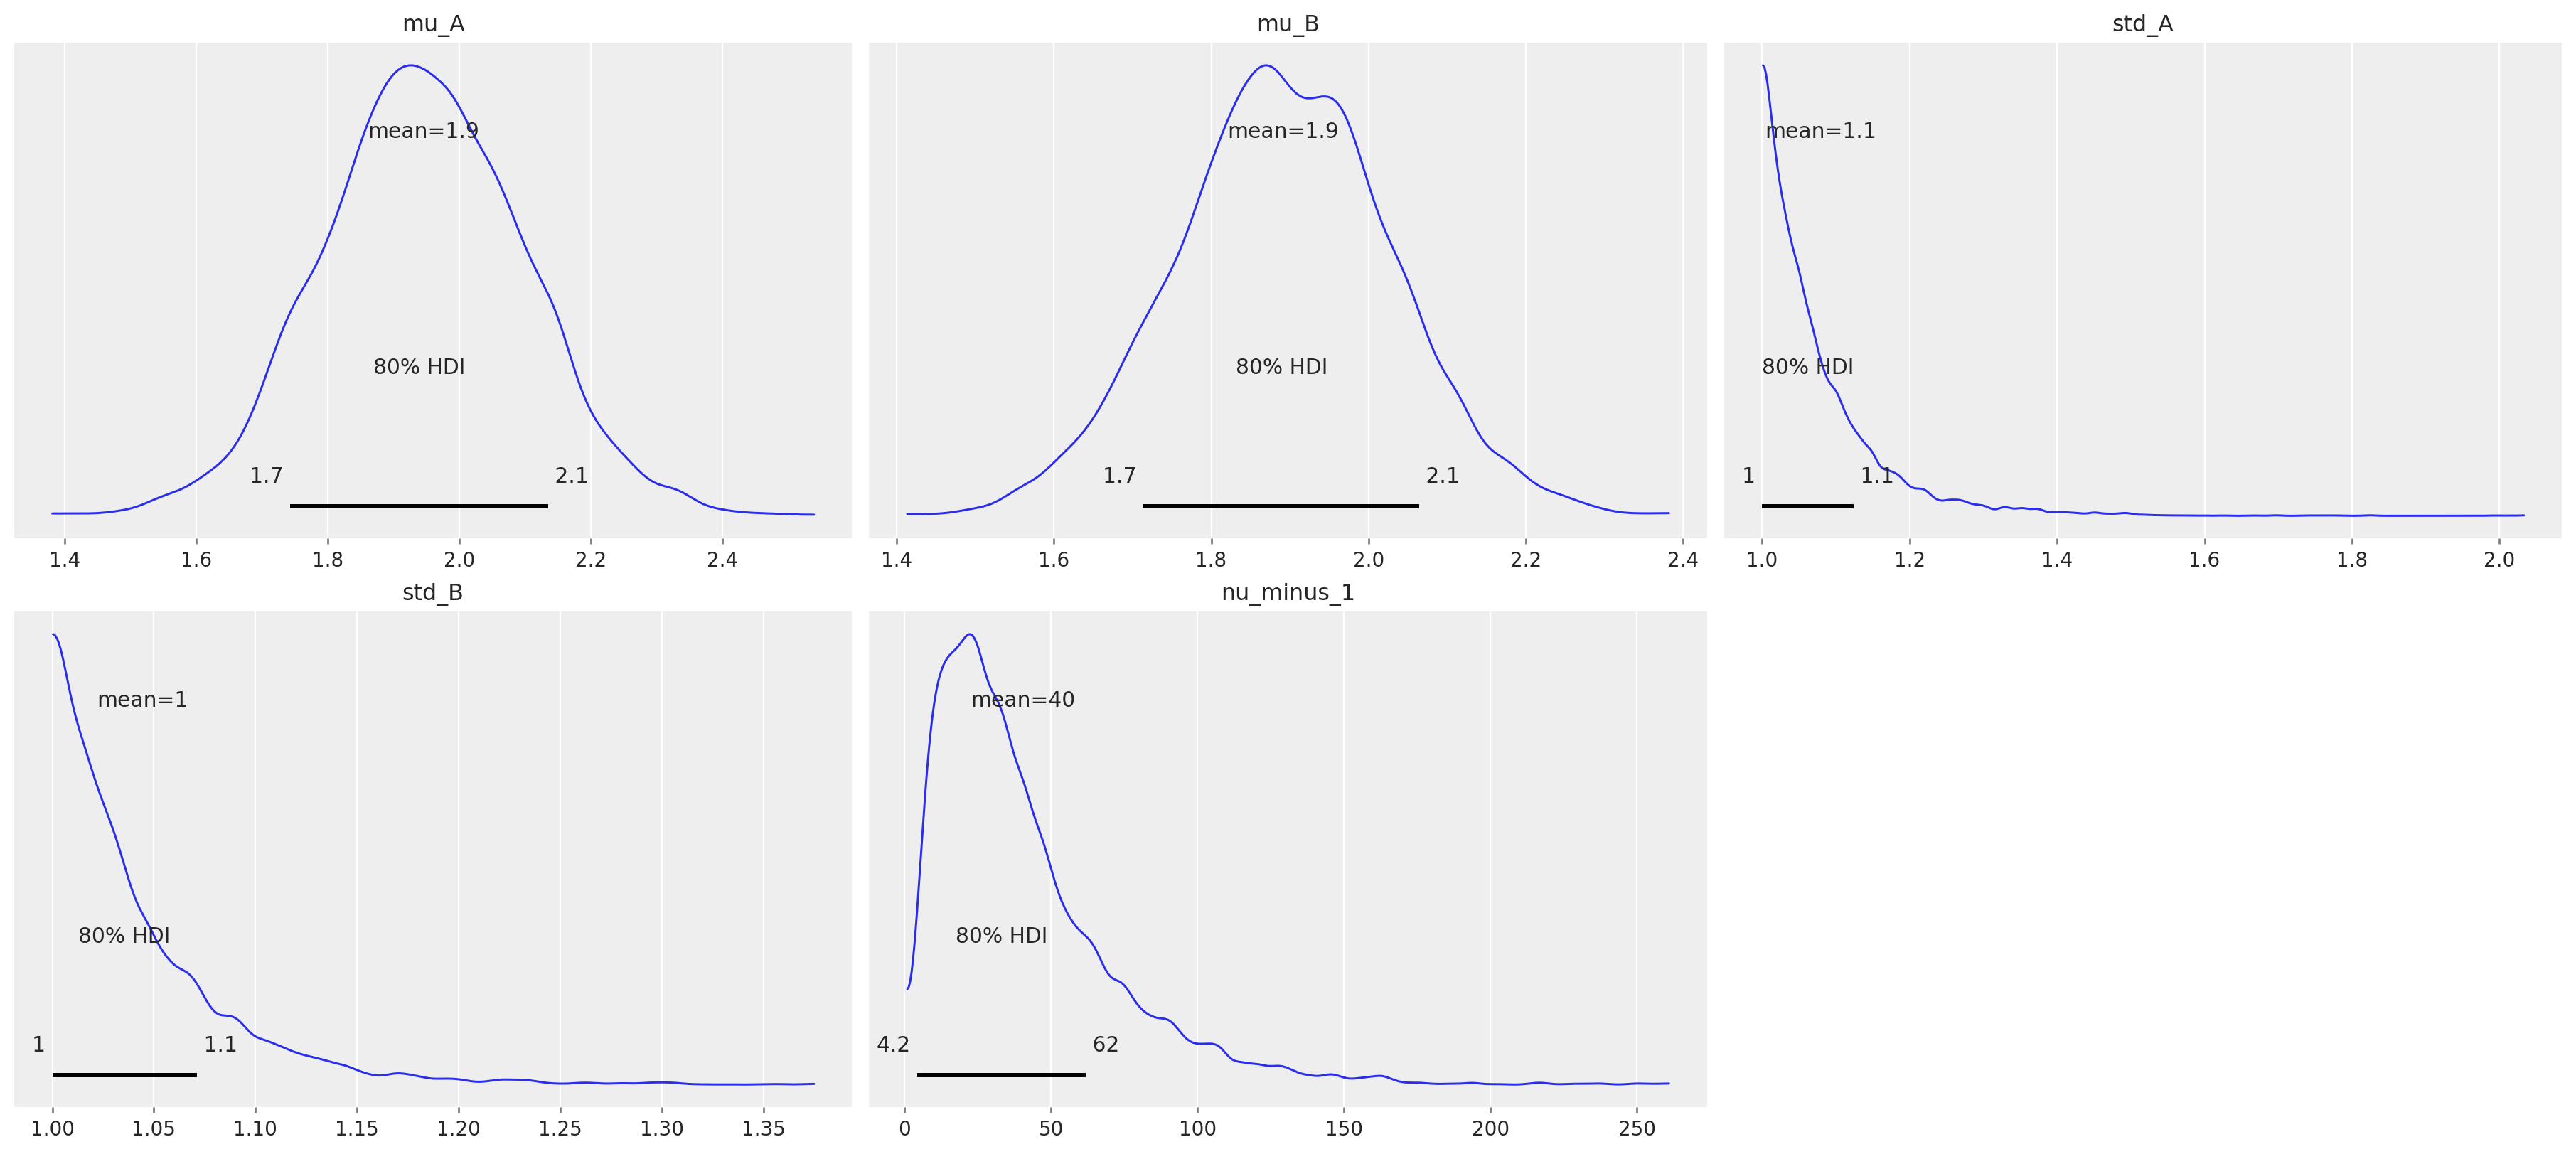

In [16]:
# posterior_samples_with_summary

# az.plot_posterior(trace, hdi_prob=0.8);

az.plot_posterior(trace, hdi_prob=0.8, figsize=(18,8), textsize=10,
                  var_names=["mu_A", "mu_B", "std_A", "std_B", "nu_minus_1"]);


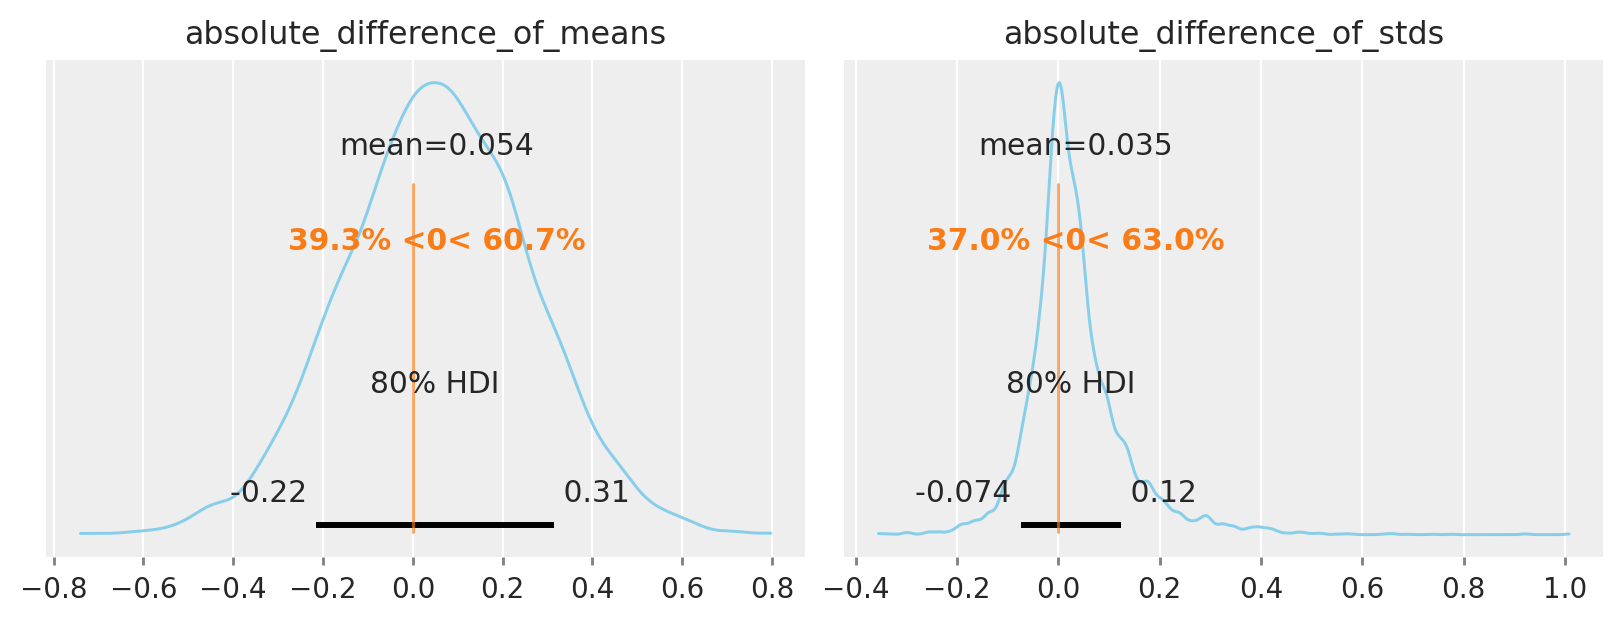

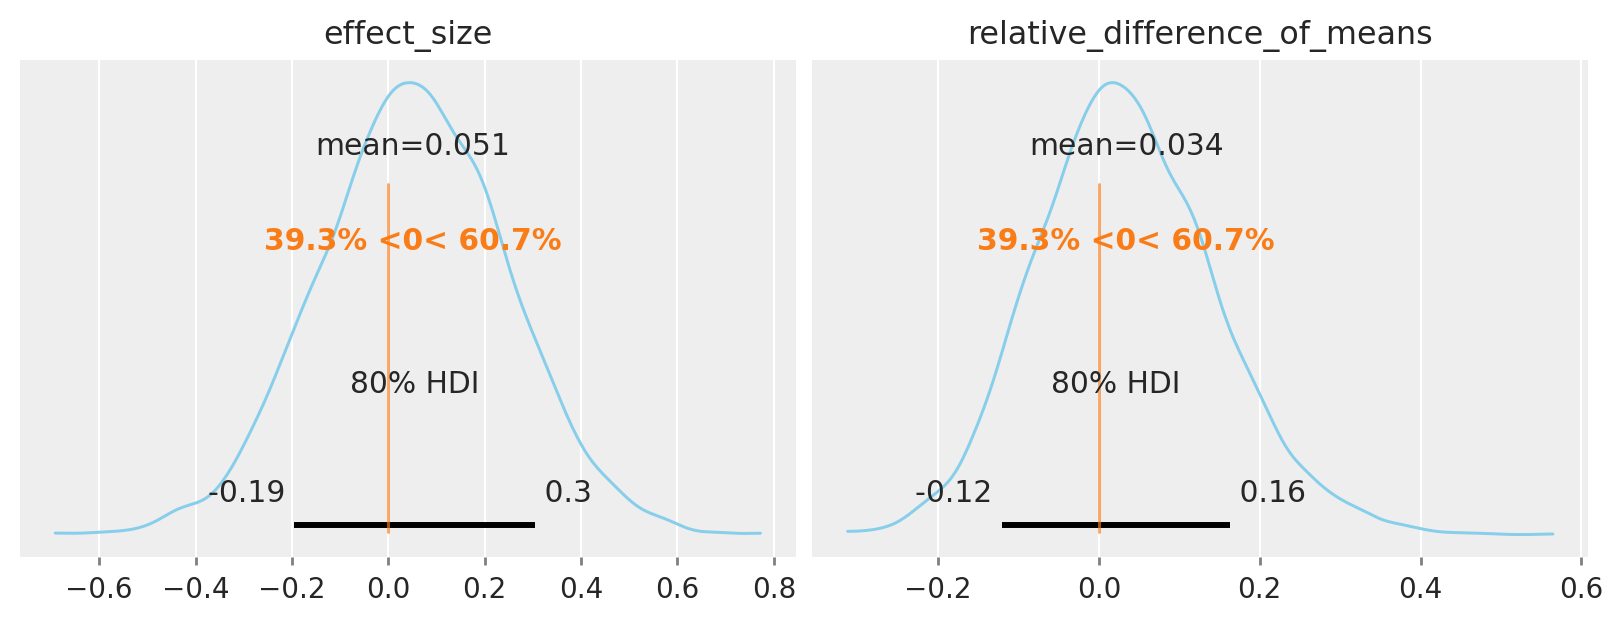

In [17]:
# posterior_samples_with_summary

az.plot_posterior(trace, hdi_prob=0.8,
                 var_names=["absolute_difference_of_means", "absolute_difference_of_stds"],
                 ref_val=0, color='#87ceeb', figsize=(8,3), textsize=10);

az.plot_posterior(trace, hdi_prob=0.8,
                 var_names=["effect_size", "relative_difference_of_means"],
                 ref_val=0, color='#87ceeb', figsize=(8,3), textsize=10);



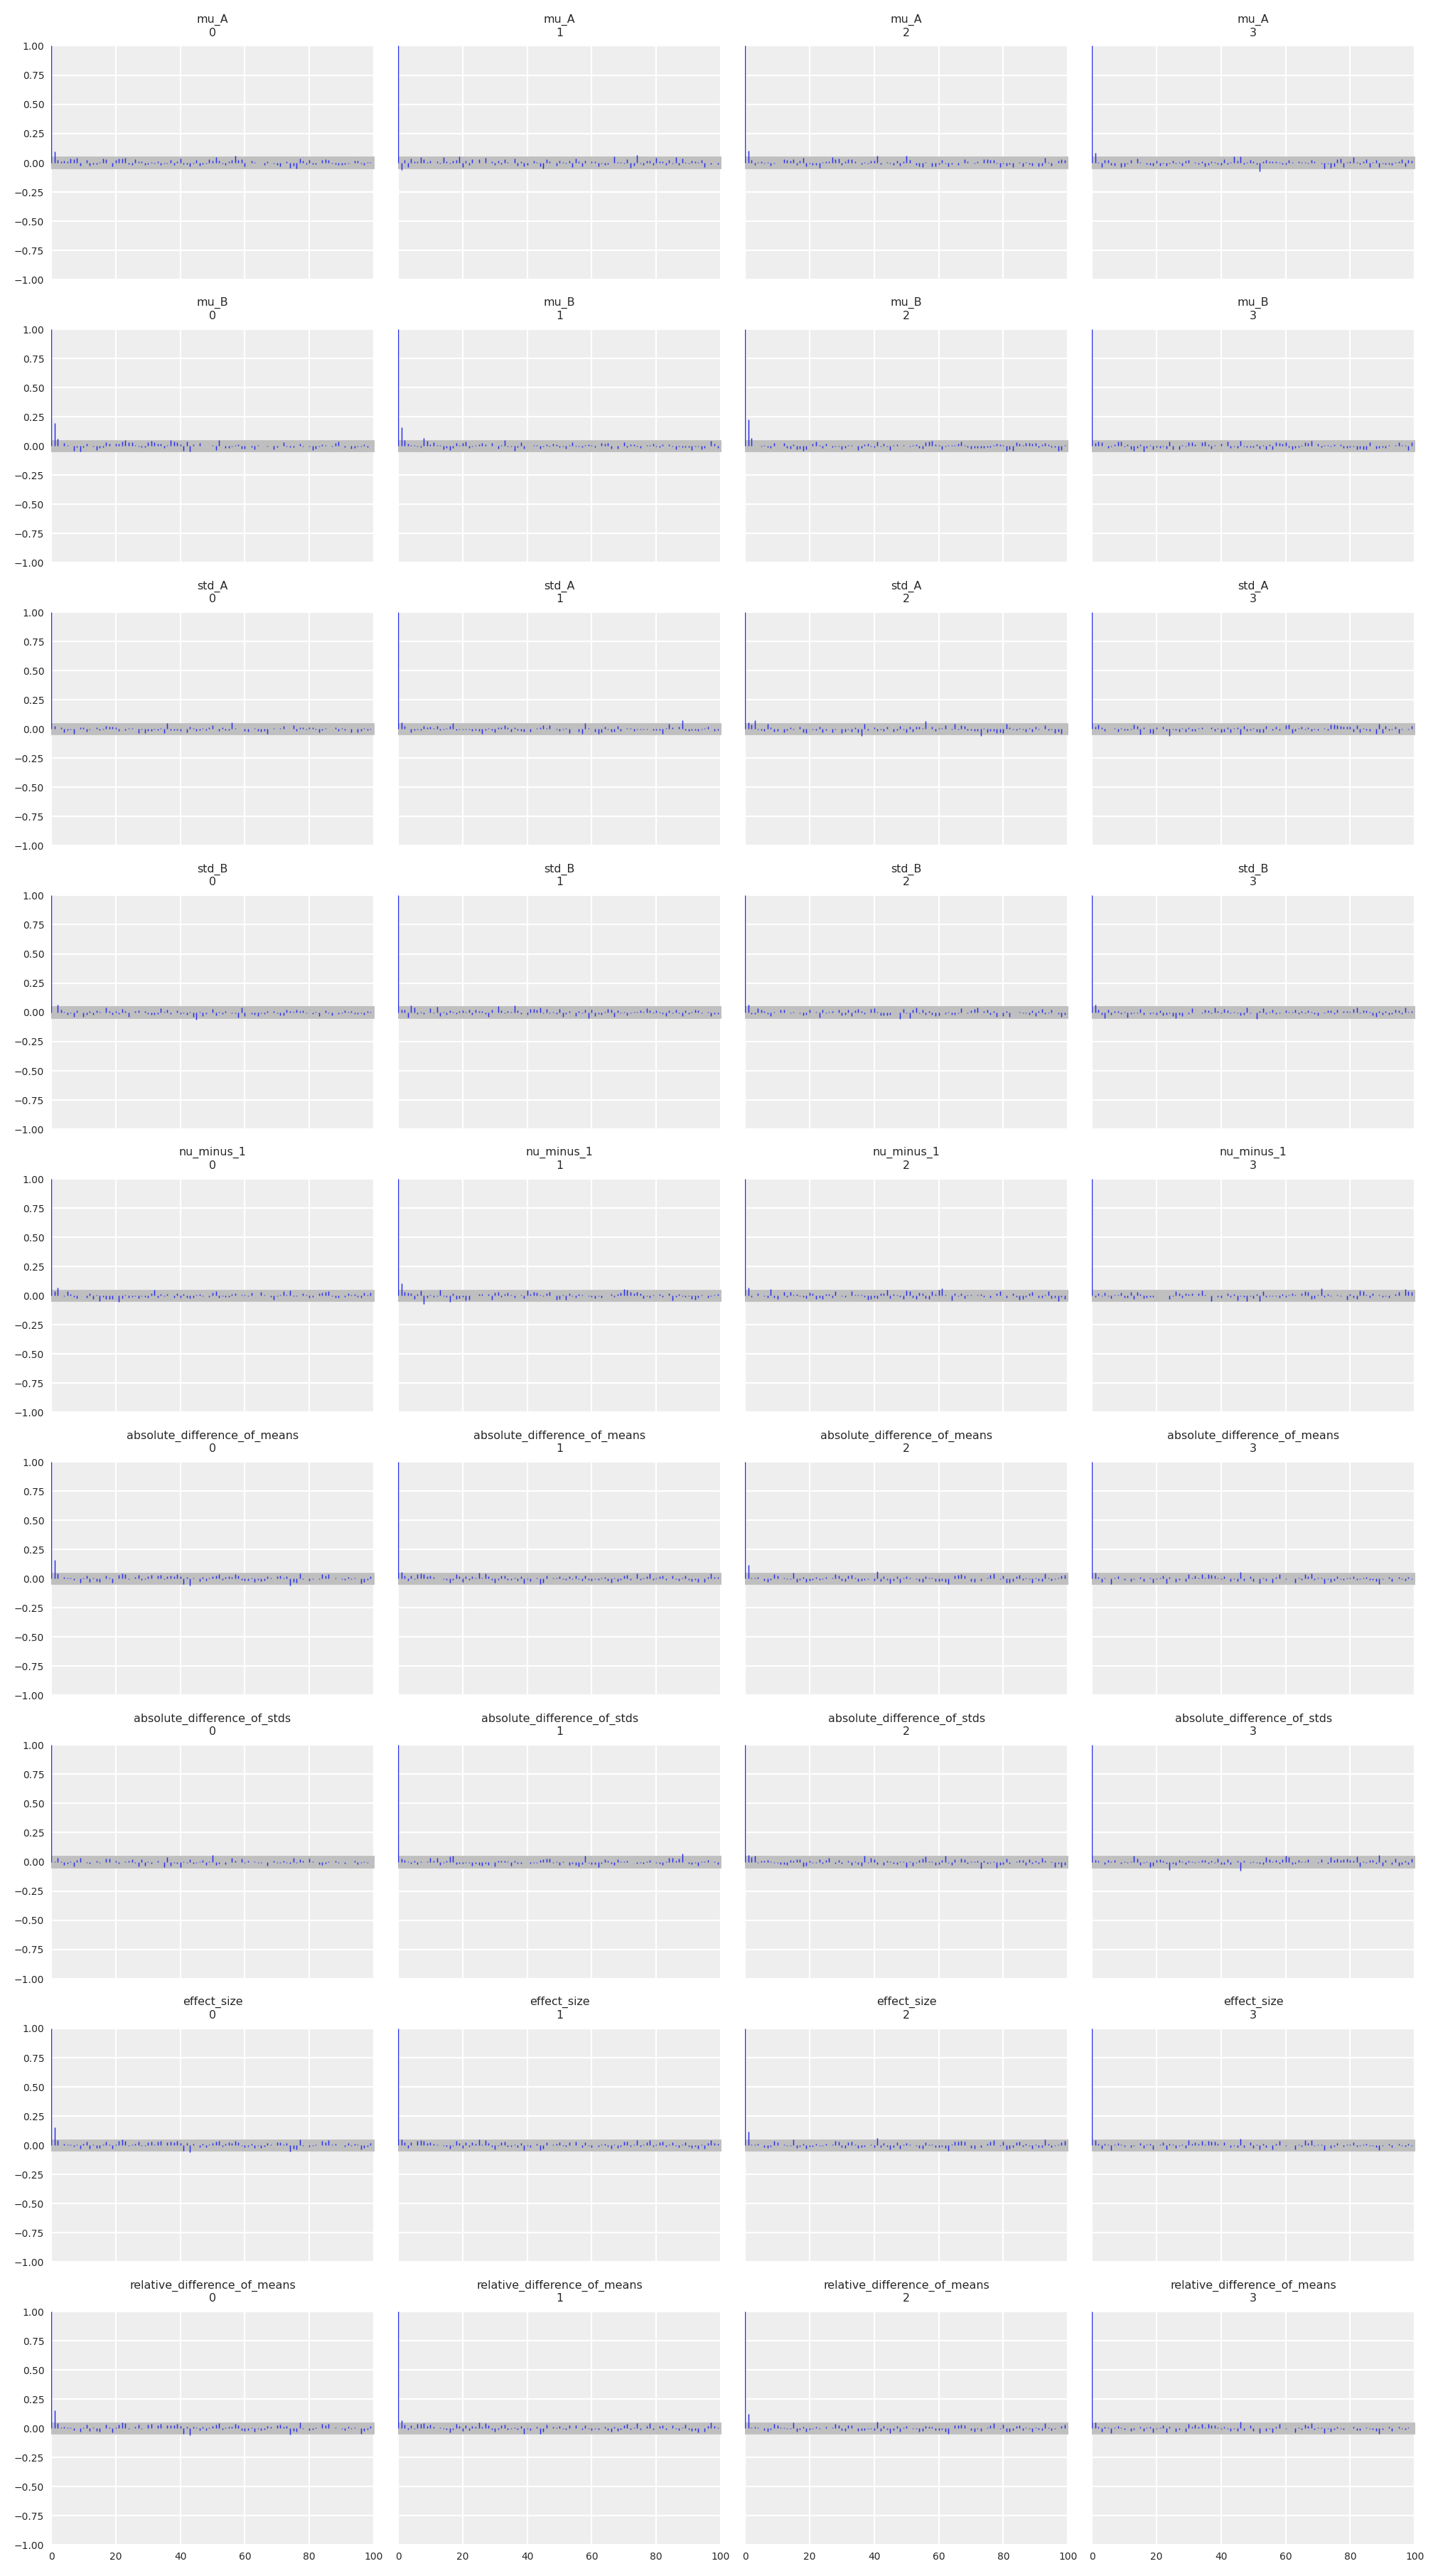

In [18]:
az.plot_autocorr(trace, figsize=(10,18), textsize=5);

hogeが0.1円以上増加する確率の平均: 41.0%


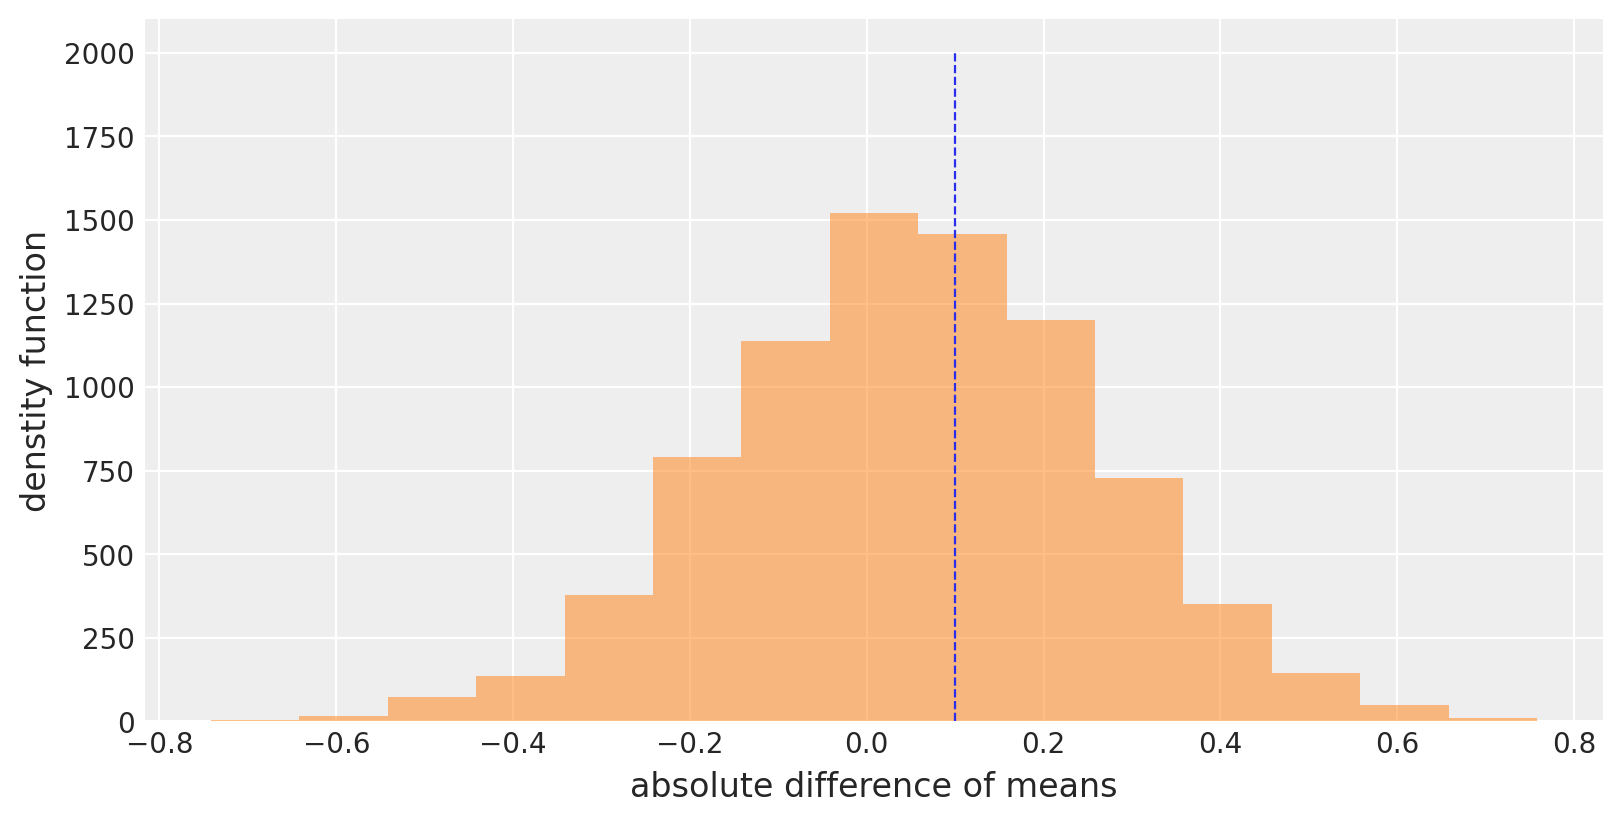

In [19]:
# 多次元配列を一次元にする
adm_array = np.array(trace.posterior['absolute_difference_of_means']).reshape(-1,)
# adm_array_minus = adm_array*(-1) # A<Bな結果のとき用（逆数にしたくて-1を掛けてる）

print('hogeが0.1円以上増加する確率の平均: {:.1f}%'.format((adm_array>=0.1).mean()*100))

plt.figure(figsize=(8,4))
plt.hist(adm_array, bins=np.arange(adm_array.min(), adm_array.max(), 0.1),
    density=False, label="posterior", color='tab:orange', alpha=0.5)
    
plt.vlines(0.1, 0, 2000, lw=0.8, linestyle='dashed')
plt.xlabel("absolute difference of means", fontsize=12)
plt.ylabel("denstity function", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

hogeが0.1円以上増加する確率の平均: 41.0%


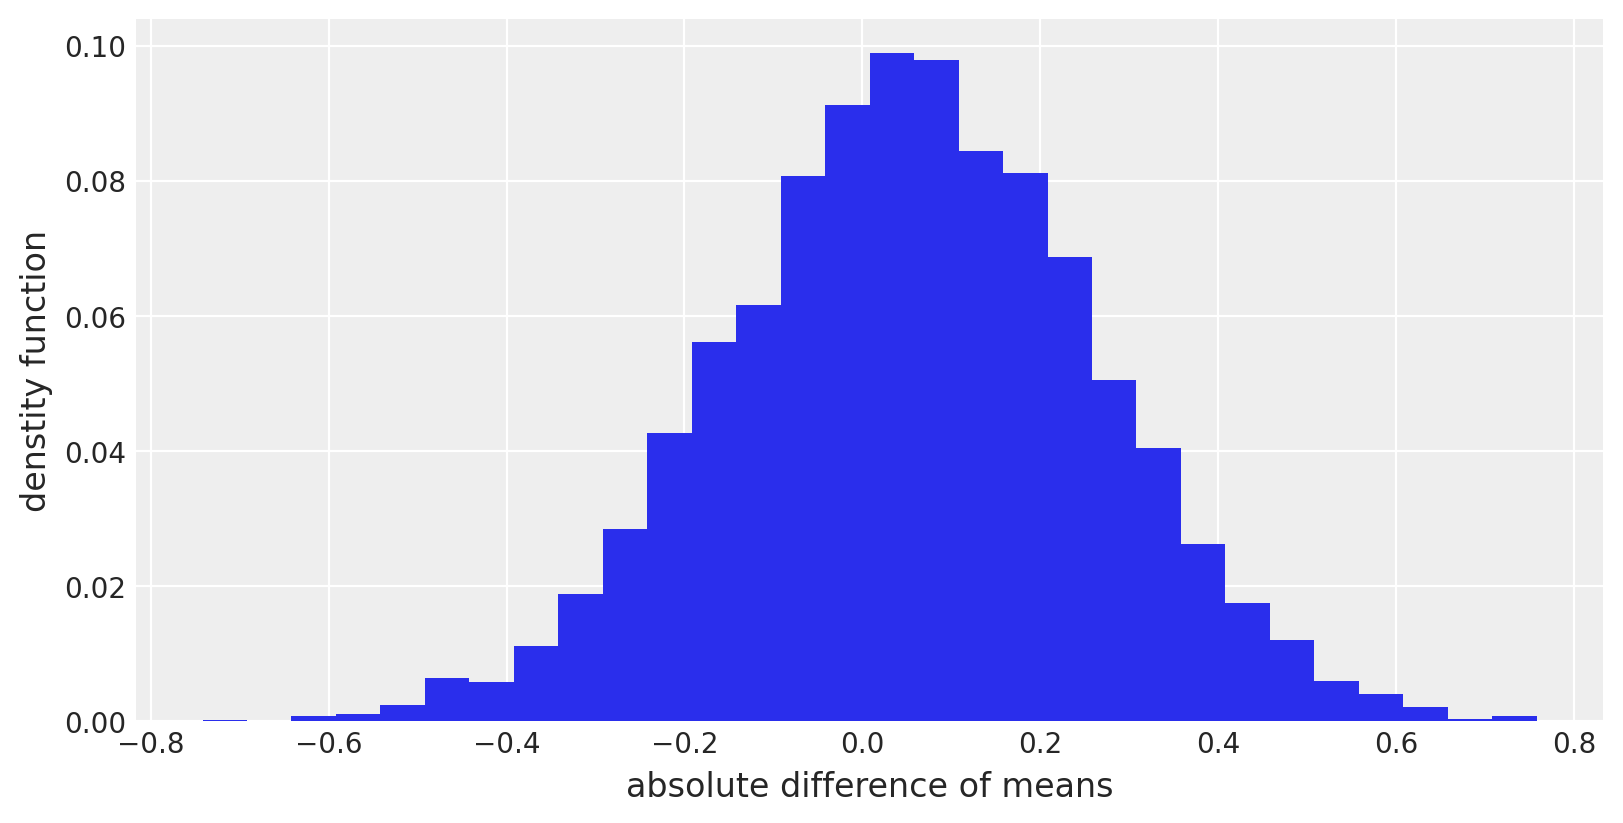

In [20]:
# 度数密度 = 度数 / 階級幅
# 相対度数密度 = 相対度数 / 階級幅
# の相対度数密度の合計を階級幅によらず1にしたい場合


# 多次元配列を一次元にする
adm_array = np.array(trace.posterior['absolute_difference_of_means']).reshape(-1,)
# adm_array_minus = adm_array*(-1) # A<Bな結果のとき用（逆数にしたくて-1を掛けてる）

print('hogeが0.1円以上増加する確率の平均: {:.1f}%'.format((adm_array>=0.1).mean()*100))

plt.figure(figsize=(8,4))

weights = np.ones(len(adm_array))/float(len(adm_array))
plt.hist(adm_array, bins=np.arange(adm_array.min(), adm_array.max(), 0.05), weights=weights)

plt.xlabel("absolute difference of means", fontsize=12)
plt.ylabel("denstity function", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()